In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy
import spiceypy as spice
import rebound
import reboundx

import sys
sys.path.append('..')
from geminids.constants import *
from geminids.weights import *

In [3]:
def cart2cyl(x):
    arr = x.copy()
    arr[:,0] = np.sqrt((x[:,0]**2) + (x[:,1]** 2))
    arr[:,1] = np.arctan2(x[:,1], x[:,0])

    
    return arr

[ 6.94387089e-01 -1.22781217e-01  2.72250900e-01  5.37906431e+08
  6.30521006e+10]


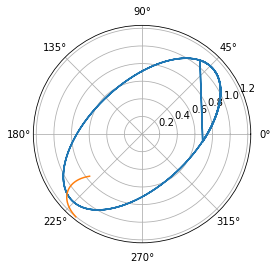

In [4]:
orbit = np.load('data/phaethon.npy')
orbit = orbit.reshape(20000,5)
orbit_orig = orbit.copy()
center = 1/2 * np.array([np.max(orbit[:,0]) + np.min(orbit[:,0]),
                         np.max(orbit[:,1]) + np.min(orbit[:,1]),
                        np.max(orbit[:,2]) + np.min(orbit[:,2])])
orbit[:,0] -= center[0]
orbit[:,1] -= center[1]
orbit[:,2] -= center[2]
orbit = cart2cyl(orbit.reshape(20000,5))
orbit_orig = cart2cyl(orbit_orig.reshape(20000,5))



print(orbit[5])
orbit = np.tile(orbit,(3,1) )
orbit[:20000,1] -= 2*np.pi
orbit[40000:,1] += 2*np.pi

orbit_orig = np.tile(orbit_orig,(3,1) )
orbit_orig[:20000,1] -= 2*np.pi
orbit_orig[40000:,1] += 2*np.pi

psp = np.load('data/psp.npy')
psp_orig = psp.copy()
psp[:,0] -= center[0]
psp[:,1] -= center[1]
psp[:,2] -= center[2]

psp = cart2cyl(psp)
psp_orig = cart2cyl(psp_orig)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})


ax.plot(orbit[:,1], orbit[:,0])
ax.plot(psp[:,1], psp[:,0])
#ax.scatter(arr[6309,1], arr[6309,0])



offset = interp1d(orbit[:,1], orbit[:,2])
radius = interp1d(orbit[:,1], orbit_orig[:,0])


offset_orig = interp1d(orbit_orig[:,1], orbit_orig[:,2])
radius_orig = interp1d(orbit_orig[:,1], orbit_orig[:,0])

In [5]:
points = []
points_orig = []
n = 100
mass = 0

for i in tqdm(range(n)):
    data = np.load(f'../output/novel/particles{i}.npy')
    beta = np.load(f'../output/novel/beta{i}.npy')
    size = np.array(asteroidal(beta))
    
    data = data.reshape(10000*100*2, 5)
    data_orig = data.copy()
    data[:,0] -= center[0]
    data[:,1] -= center[1]
    data[:,2] -= center[2]
    
    data = cart2cyl(data[:,0:3])
    data_orig = cart2cyl(data_orig[:,0:3])
    mass += np.sum(size[(~np.isnan(size * weight_novel(beta)))] * 
                   weight_novel(beta[(~np.isnan(size * weight_novel(beta)))]))
#     data[:,2] -= offset(data[:,1])
    
    
    points.append(np.hstack((data, np.tile(size,20000).reshape(2000000,1), 
                              np.tile(weight_novel(beta),20000).reshape(2000000,1))))
    points_orig.append(np.hstack((data_orig, np.tile(size,20000).reshape(2000000,1),
                                   np.tile(weight_novel(beta),20000).reshape(2000000,1))))
points = np.array(points)
points = points.reshape(2000000*n,5)
points_orig = np.array(points_orig)
points_orig = points_orig.reshape(2000000*n,5)

norm = 1e15/(mass * 20000)

  0%|          | 0/100 [00:00<?, ?it/s]../geminids/beta2mass.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return a* x**-b
<ipython-input-5-b5399a352ab2>:19: RuntimeWarning: invalid value encountered in multiply
  mass += np.sum(size[(~np.isnan(size * weight_novel(beta)))] *
<ipython-input-5-b5399a352ab2>:20: RuntimeWarning: invalid value encountered in multiply
  weight_novel(beta[(~np.isnan(size * weight_novel(beta)))]))
100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


In [6]:
len(points[:,3])

200000000

In [7]:
norm

90961702478.32661

In [8]:
i = np.argmax(orbit[:,0][np.logical_and(-np.pi<orbit[:,1], orbit[:,1]<0)])

t_min = orbit[np.logical_and(-np.pi<orbit[:,1], orbit[:,1]<0)][i,1]
print(t_min)  

i = np.argmax(orbit[:,0][np.logical_and(0<orbit[:,1], orbit[:,1]<np.pi)]) #6309
t_max = orbit[[np.logical_and(0<orbit[:,1], orbit[:,1]<np.pi)]][i,1]
print(t_max)

print(abs(t_min-t_max))


# t_min = t_max + np.pi
# t_min, t_max = t_max, t_min
t_max = t_max - 0*np.pi
t_min = t_min - 0*np.pi

print(t_min, t_max)


# i = np.argmin(orbit[:,0][np.logical_and(np.abs(orbit[:,1], orbit[:,1])<np.pi)])

# t_min_orig = orbit[np.logical_and(-np.pi<orbit[:,1], orbit[:,1]<0)][i,1]
# print(t_min_orig)  

# i = np.argmax(orbit[:,0][np.logical_and(np.abs(orbit[:,1], orbit[:,1])<np.pi)]) #6309
# t_max_orig = orbit[[np.logical_and(0<orbit[:,1], orbit[:,1]<np.pi)]][i,1]
# print(t_max_orig)

# print(abs(t_min_orig-t_max_orig))


# # t_min = t_max + np.pi
# t_min_orig, t_max_orig = t_max_orig, t_min_orig

-2.3889198105462714
0.7522299514080371
3.1411497619543085
-2.3889198105462714 0.7522299514080371


<ipython-input-8-5dcbf6973b6b>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  t_max = orbit[[np.logical_and(0<orbit[:,1], orbit[:,1]<np.pi)]][i,1]


<ipython-input-9-7f2f140156f8>:4: RuntimeWarning: invalid value encountered in less
  mask = np.logical_and(np.logical_and(np.abs(points[:,2]) < 10,  np.logical_and(points[:,1] <t_max,


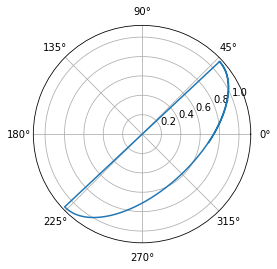

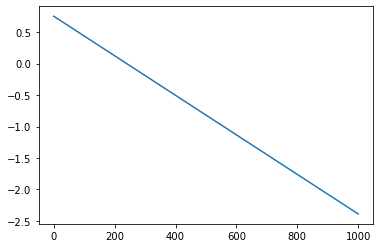

100%|██████████| 1000/1000 [06:40<00:00,  2.49it/s]


In [9]:
n = 1000
r_max = 1.0

mask = np.logical_and(np.logical_and(np.abs(points[:,2]) < 10,  np.logical_and(points[:,1] <t_max,
                                                                points[:,1] > t_min)), points[:,0] < 2.2)


psp_mask = np.logical_and(np.abs(psp[:,2]) < 10,  np.logical_and(psp[:,1] < t_max,
                                                                 psp[:,1] > t_min))

orbit_mask = np.logical_and(np.abs(orbit[:,1]) < np.pi,  np.logical_and(orbit[:,1] < t_max,
                                                                 orbit[:,1] > t_min))

arr = points[mask].copy()

psp_arr = psp[psp_mask].copy()


orb_arr = orbit[orbit_mask].copy()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(orb_arr[:,1], orb_arr[:,0])
plt.show()


# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.scatter(arr[:,1], arr[:,0])
# plt.show()
# orb_orig_arr = orbit_orig[orbit_mask].copy()
theta = interp1d(orb_arr[:,0], orb_arr[:,1])



bounds = np.linspace(t_max, t_min, n+1)
                        

# bounds_orig = theta(np.linspace(orb_orig_arr[:,0][np.logical_and(-np.pi<orb_orig_arr[:,1], orb_orig_arr[:,1]<0)].max(), 
#                            orb_orig_arr[:,0][np.logical_and(0<orb_orig_arr[:,1], orb_orig_arr[:,1]<np.pi)].max(), n+1 ))
plt.plot(np.arange(n+1), bounds)
plt.show()
ax.plot(arr[:,1], arr[:,0])
plt.show()

for i in tqdm(range(n)):
    mask = np.logical_and(arr[:,1] <= bounds[i], arr[:,1] > bounds[i+1])
    psp_mask = np.logical_and(psp_arr[:,1] <= bounds[i], psp_arr[:,1] > bounds[i+1])
    orb_mask = np.logical_and(orb_arr[:,1] <= bounds[i], orb_arr[:,1] > bounds[i+1])
    
#     fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})


#     ax.scatter(arr[:,1][mask], arr[:,0][mask])
#     ax.plot(orbit[:,1], orbit[:,0])

#     plt.show()
    
    if ((bounds[i] - bounds[i+1]) < 0):
        raise
        mask = np.logical_or(arr[:,1] <= bounds[i], arr[:,1] > bounds[i+1])
        psp_mask = np.logical_or(psp_arr[:,1] <= bounds[i], psp_arr[:,1] > bounds[i+1])
        orb_mask = np.logical_or(orb_arr[:,1] <= bounds[i], orb_arr[:,1] > bounds[i+1])
    elif (i==n): 
        raise
        mask = np.logical_and(arr[:,1] <= bounds[i], arr[:,1] > bounds[i])
        psp_mask = np.logical_and(psp_arr[:,1] <= bounds[i], psp_arr[:,1] > bounds[i])
        orb_mask = np.logical_and(orb_arr[:,1] <= bounds[i], orb_arr[:,1] > bounds[i])
    
    

    offset_r = np.mean(orb_arr[:,0][orb_mask])


    
    
    offset_z = np.mean(orb_arr[:,2][orb_mask])


    
    arr[:,2][mask] -= offset_z

    orb_arr[:,2][orb_mask] -= offset_z
    psp_arr[:,2][psp_mask] -=offset_z

    arr[:,0][mask] -= offset_r

    orb_arr[:,0][orb_mask] -= offset_r
    psp_arr[:,0][psp_mask] -=offset_r


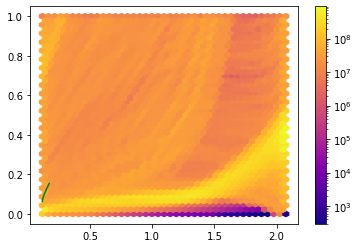

In [10]:
mask = (np.sqrt(arr[:,0]**2 + arr[:,2]**2) < 1) * (arr[:,1] > t_min)
psp_mask = (np.abs(psp_arr[:,2]) + np.abs(psp_arr[:,0])) < 200
orb_mask = np.abs(orb_arr[:,2] < 100)

hi = 6038
n=40
plt.rc_context({'figure.facecolor':'white'})
poly = plt.hexbin(radius((arr[:,1][mask])), np.sqrt(arr[:,0][mask]**2 + arr[:,2][mask]**2), 
                  cmap = 'plasma', gridsize = n, bins='log', C = arr[:,4][mask], 
                 reduce_C_function = np.sum)
plt.plot(radius((psp_arr[:,1][psp_mask])), np.sqrt(psp_arr[:,0][psp_mask]**2 + psp_arr[:,2][psp_mask]**2), c = 'g')
# poly = plt.hexbin((arr[:,1][mask]), np.sqrt(arr[:,0][mask]**2 + arr[:,2][mask]**2), cmap = 'plasma', gridsize = n, bins='log')
# plt.plot((psp_arr[:,1][psp_mask]), np.sqrt(psp_arr[:,0][psp_mask]**2 + psp_arr[:,2][psp_mask]**2), c = 'g')


# plt.clim(10**3.5,5e5)
plt.colorbar()
plt.show()

In [11]:
norm

90961702478.32661

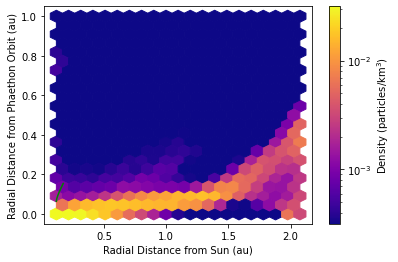

In [12]:
c = poly.get_array().copy()
cords = poly.get_offsets().copy()

# dr = np.abs(cords[252,0]-cords[0,0])
# dl = np.abs(cords[252,1]-cords[0,1])

dl = (2.1/(n+2))
dr = (1/(n+6))

for i in range(cords.shape[0]): #currently estimating hexes as squares #TODO
    r = cords[i,1]
    l = cords[i,0]
    
    r1 = r - dr/2
    r2 = r + dr/2
    
    l1 = (l - dl/2)
    l2 = (l+dl/2)
    
    h = np.abs(np.max((l1,0))-np.max((l2,0)))
    V = np.pi * np.abs(np.max((r2,0))**2 - np.max((r1,0))**2)*h *((au/1e3)**3)
    c[i] /= V
    



plt.hexbin(cords[:,0], cords[:,1], C=c*norm, gridsize=20, bins='log', cmap='plasma')
plt.plot((radius(psp_arr[:,1][psp_mask])), np.sqrt(psp_arr[:,0][psp_mask]**2 + psp_arr[:,2][psp_mask]**2), c = 'g')
# plt.clim(1e4, 1e12)


plt.colorbar(label="Density (particles/km$^3$)")
plt.clim(10**-3.5,10**-1.5)
plt.xlabel("Radial Distance from Sun (au)")
plt.ylabel("Radial Distance from Phaethon Orbit (au)")
plt.savefig("../figures/Fig_5.1.1.eps")
plt.show()

In [13]:
x_min = 0
x_max = 2.2
y_min = 0
y_max = 1

n = 30

means = np.zeros((n,n))
cords = np.zeros((n,n,2))

x_lim = np.linspace(x_min, x_max, n+1)
y_lim = np.linspace(y_min, y_max, n+1)

x = radius(arr[:,1])
y = np.sqrt(arr[:,0]**2 + arr[:,2]**2)
for i in tqdm(range(n)):
    for j in range(n):
        m_x = np.logical_and(x >= x_lim[i], x < x_lim[i+1])
        m_y = np.logical_and(y >= y_lim[j], y < y_lim[j+1])
        
        cords[i,j] = [(x_lim[i]+x_lim[i+1])/2, (y_lim[j]+y_lim[j+1])/2]
        
        means[i][j] = np.sum(arr[:,3][np.logical_and(m_x, m_y)] 
                              * arr[:,4][np.logical_and(m_x, m_y)]) / np.sum(
            arr[:,4][np.logical_and(m_x, m_y)])
        
cords = cords.reshape(n**2,2)
means = means.reshape(n**2,)



  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-13-ef1c344f014e>:23: RuntimeWarning: invalid value encountered in double_scalars
  means[i][j] = np.sum(arr[:,3][np.logical_and(m_x, m_y)]
  3%|▎         | 1/30 [00:07<03:32,  7.33s/it]<ipython-input-13-ef1c344f014e>:23: RuntimeWarning: invalid value encountered in multiply
  means[i][j] = np.sum(arr[:,3][np.logical_and(m_x, m_y)]
100%|██████████| 30/30 [04:14<00:00,  8.47s/it]


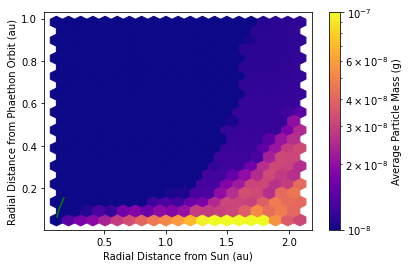

In [17]:
plt.hexbin(cords[:,0], cords[:,1], C=means, gridsize = 20, cmap="plasma", bins = 'log')
plt.plot((radius(psp_arr[:,1][psp_mask])), np.sqrt(psp_arr[:,0][psp_mask]**2 + psp_arr[:,2][psp_mask]**2), c = 'g')


plt.colorbar(label="Average Particle Mass (g)")
plt.xlabel("Radial Distance from Sun (au)")
plt.ylabel("Radial Distance from Phaethon Orbit (au)")
plt.clim(10**-8, 1e-7)
plt.savefig("../figures/Fig_5.1.2.eps")
plt.show()

In [15]:
cords[0,1] + dr/2

0.02753623188405797